In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal

## Import data and calculate GF

In [2]:
#define our output grid size

ds_nbp_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.625, 360., 1.25)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(0, 361, 1.25))
    }
)

A_nbp = utils.find_area(ds_nbp_out, R = 6.3781e6) #convert to m2

In [3]:
#define our output grid size

ds_fgco2_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.5, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

A_fgco2 = utils.find_area(ds_fgco2_out, R = 6.3781e6) #convert to m2

In [4]:
ds_control, ds_pulse, G =  utils.import_regrid_calc('cmip6_data/co2mass_Amon_GFDL-ESM4_esm-piControl*', 
                         'cmip6_data/co2mass_Amon_GFDL-ESM4_esm-pi-CO2pulse_r1i1p1f1_gn_010101-020012.nc', 
                         ds_fgco2_out, 'co2mass', pulse_size = 100, replace_xy = False, regrid = False) # 100GtC/kg

In [5]:
## import a second CO2 response based on Joos

rcp_85_response = pd.read_csv('Joos_8.5_RCP.csv', header = None, index_col = 0)

rcp_85_ds = xr.Dataset(data_vars = dict(co2_response = (['year'], rcp_85_response[1].values)),
            #dims = ['time'],
            coords = dict(year = ('year', rcp_85_response.index))
            )

rcp_85_ds = rcp_85_ds.interp(year = np.arange(1,101,1), method = 'linear')

rcp_85_ds['co2_response'] = rcp_85_ds['co2_response']*G[0]

rcp_85_ds['year'] = G['year']

rcp_85_ds['co2_response'][0] = G[0]

In [6]:
fg_co2_pulse_ds = xr.open_mfdataset('cmip6_data/fgco2_Omon_GFDL-ESM4_1pct*') #kg/m2/s
nbp_pulse_ds = xr.open_mfdataset('cmip6_data/nbp_Lmon_GFDL-ESM4_1pct*') #kg/m2/s

In [7]:
fg_co2_pictrl_ds = xr.open_mfdataset('cmip6_data/fgco2_Omon_GFDL-ESM4_esm-pi*') #kg/m2/s
nbp_pictrl_ds = xr.open_mfdataset('cmip6_data/nbp_Lmon_GFDL-ESM4_esm-pi*') #kg/m2/s

In [8]:
co2_1pct_ds = xr.open_mfdataset('cmip6_data/co2mass_Amon_GFDL-ESM4_1pctCO2*') #kg
co2_pictrl_ds = xr.open_mfdataset('cmip6_data/co2mass_Amon_GFDL-ESM4_esm-piControl*') #kg

In [9]:
#convert kg to kg/year
seconds_per_yr = 60*60*24*365
co2_1pct_ds['G_atm'] = co2_1pct_ds['co2mass'].diff('time')/(co2_1pct_ds['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
co2_pictrl_ds['G_atm'] = co2_pictrl_ds['co2mass'].diff('time')/(co2_pictrl_ds['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr

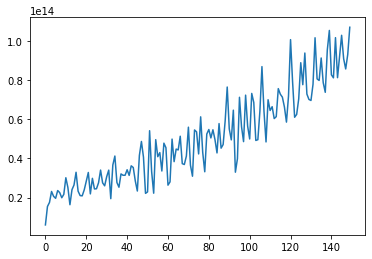

In [10]:
plt.plot(co2_1pct_ds['G_atm'].groupby('time.year').mean())

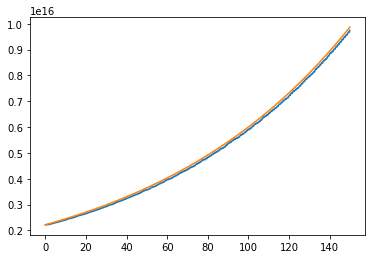

In [12]:
t = np.arange(0, 1800)/12.
plt.plot(t, co2_1pct_ds['co2mass'])
plt.plot(t, co2_1pct_ds['co2mass'][0].values*1.01**t)

In [13]:
# fg_co2_pulse_ds = utils._regrid_ds(fg_co2_pulse_ds, ds_fgco2_out)
# nbp_pulse_ds = utils._regrid_ds(nbp_pulse_ds, ds_nbp_out)

# fg_co2_pictrl_ds = utils._regrid_ds(fg_co2_pictrl_ds, ds_fgco2_out)
# nbp_pictrl_ds = utils._regrid_ds(nbp_pictrl_ds, ds_nbp_out)

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


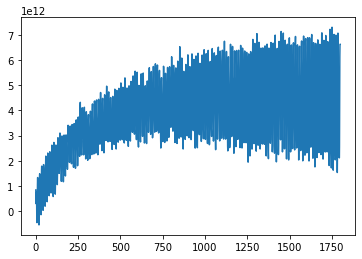

In [14]:
plt.plot((fg_co2_pulse_ds['fgco2']*seconds_per_yr*A_fgco2).sum(dim = ['lat','lon']))

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


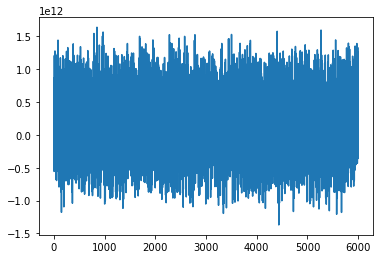

In [15]:
plt.plot((fg_co2_pictrl_ds['fgco2']*seconds_per_yr*A_fgco2).sum(dim = ['lat','lon']))

In [16]:
fg_co2_ds = fg_co2_pulse_ds - fg_co2_pictrl_ds
nbp_ds = nbp_pulse_ds - nbp_pictrl_ds

In [17]:
fg_co2_ds['fgco2'] = fg_co2_ds['fgco2']*seconds_per_yr*A_fgco2
nbp_ds['nbp'] = nbp_ds['nbp']*seconds_per_yr*A_nbp

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

## Concentration response

G.plot()
rcp_85_ds['co2_response'].plot()
plt.title('CO2 Concentration Response to Pulse of 100GtC', fontsize = 14)
plt.ylim(0,None)

## Create a compounding concentration profile

init_co2 = 2.21718909e+15 #estimated from initial co2 mass above from control ***need to fix*** #284.3 #ppm https://gmd.copernicus.org/articles/10/2057/2017/
pct_increase = 0.01
years_increase = 99
co2_arr = utils.compound_mult(init_co2, years_increase, pct_increase) - init_co2 ## add this on np.ones(100)*init_co2 ##remove init_co2 from arry so it is 1
#co2_arr = np.concatenate((np.ones(100)*init_co2, co2_arr))
#co2_arr = np.concatenate((co2_arr, np.ones(10)*co2_arr[-1]))
##stops at 140 bc quadrupling

plt.plot((co2_arr + init_co2)/init_co2)
plt.title('1pct Increase in CO2 Concentration until 4x')

## calculate the first emissions time-step

def calc_emis_fit_1pct(G, co2_arr):
    '''Calculate an emissions profile that fits our 1pct increase in concentration by convolving a CO2 concentration 
    response to emissions Green's function with the initial emissions, summing, and backing out our emissions step by step'''
    E = {}
    conv_out = {}
    conv_sum = {}
    ## kg/(kg/GtC) --> GtC Units
    #calculate emissions from our first time step
    E[0] = co2_arr[0]/G[0].values
    #calculate our second timestep
    conv_out[0] = signal.convolve(np.array(G), E[0][..., None], mode = 'same')
    E[1] = (co2_arr[1]-conv_out[0][1])/G[0].values
    #create a sum of our convolution
    conv_sum[1] = conv_out[0]
    #loop across our time range
    for i in np.arange(2,100):
       # print(i)
        #print(signal.convolve(np.array(G), E[i-1][..., None], mode = 'same'))
        conv_out[i-1] = signal.convolve(np.array(G), E[i-1][..., None], mode = 'same')
        #print(np.append(np.zeros(i),conv_out[i-1][:-i]).shape)
        conv_sum[i] = conv_sum[i-1] + np.append(np.zeros(i),conv_out[i-1][:-i])
        #print(conv_sum[i-1])
        E[i] = (co2_arr - conv_sum[i])[i]/G[0].values
        #print(E[i])
    return(E)

E_base = calc_emis_fit_1pct(G, co2_arr)

E_85 = calc_emis_fit_1pct(rcp_85_ds.co2_response, co2_arr)

conv_base = signal.convolve(np.array(G), np.array(list(E_base.values())), mode = 'full')
conv_rcp85 = signal.convolve(np.array(rcp_85_ds.co2_response), np.array(list(E_85.values())), mode = 'full')

plt.plot(co2_arr, label = 'model')
plt.plot(conv_rcp85, label = 'convolution for rcp 8.5', linestyle = '--')
plt.plot(conv_base, label = 'convolution for our base', linestyle = '--')
plt.legend()
plt.xlim(0,100)
#plt.ylim(0,4e15)

## calculate emissions according to liddicoat et al. 2021

emis_co2_ds = co2_atm_ds['co2mass'] + fg_co2_ds['fgco2'] + nbp_ds['nbp']

GtC_per_ppm = 2.124 #GtC/ppm estimated from Ballantyne et al 2015
GtC_per_kgC = 10e15 #1 GtCO2 = 1 PgC = 10E15 gC

init_co2 = 284.3 #ppm ###2.21718909e+15 #estimated from initial co2 mass above from control ***need to fix*** #284.3 #ppm https://gmd.copernicus.org/articles/10/2057/2017/
init_co2*=GtC_per_ppm
pct_increase = 0.01
years_increase = 99
#co2_arr = utils.compound_mult(init_co2, years_increase, pct_increase) - init_co2 ## add this on np.ones(100)*init_co2 ##remove init_co2 from arry so it is 1
#co2_arr = np.concatenate((np.ones(100)*init_co2, co2_arr))
#co2_arr = np.concatenate((co2_arr, np.ones(10)*co2_arr[-1]))
##stops at 140 bc quadrupling

G_atm_1pct = ((utils.compound_mult(init_co2, years_increase, pct_increase)))#[...,None, None]

In [18]:
co2_dif = co2_1pct_ds['G_atm'] - co2_pictrl_ds['G_atm'] #kg/yr

years = pd.date_range("2000-01-01", freq="Y", periods=years_increase+1)

G_atm_1pct_ds = xr.Dataset(data_vars = dict(co2_response = (['year'], G_atm_1pct/12)),
            #dims = ['time'],
            coords = dict(year = ('year', years))
            )

G_atm_1pct_ds = G_atm_1pct_ds.resample(year = '1M').interpolate("cubic")

plt.plot(G_atm_1pct_ds['co2_response'])

nbp_ds = nbp_ds.groupby('time.year').mean()
fg_co2_ds = fg_co2_ds.groupby('time.year').mean()

Text(0, 0.5, 'annual mean total ocean sink, kg/yr')

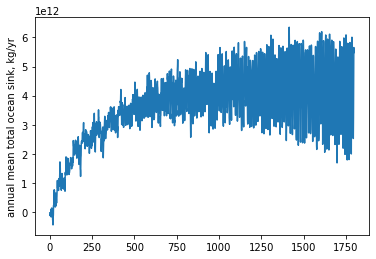

In [19]:
plt.plot(fg_co2_ds['fgco2'].sum(dim = ['lat','lon']))
plt.ylabel('annual mean total ocean sink, kg/yr')

Text(0, 0.5, 'annual mean total land sink, kg/yr')

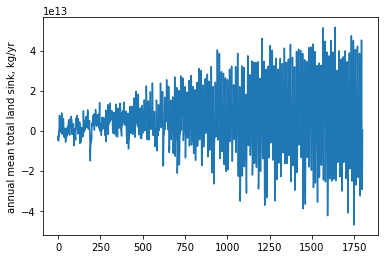

In [20]:
plt.plot(nbp_ds['nbp'].sum(dim = ['lat','lon']))
plt.ylabel('annual mean total land sink, kg/yr')

Text(0, 0.5, 'annual mean total sinks, kg')

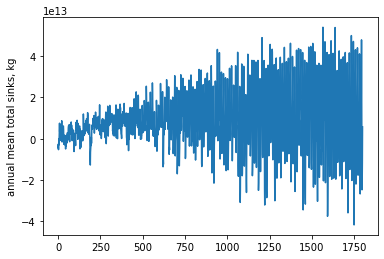

In [21]:
plt.plot(nbp_ds['nbp'].sum(dim = ['lat','lon']) + fg_co2_ds['fgco2'].sum(dim = ['lat','lon']))
plt.ylabel('annual mean total sinks, kg')

In [22]:
emis_sinks = nbp_ds['nbp'].sum(dim = ['lat','lon']) + fg_co2_ds['fgco2'].sum(dim = ['lat','lon'])

In [23]:
times = pd.date_range('2000', periods=len(emis_sinks['time']), freq='MS')
weights = times.shift(1, 'MS') - times
weights = xr.DataArray(weights, [('time', emis_sinks['time'].values)]).astype('float')

In [24]:
emis_sinks =  (emis_sinks * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


Text(0, 0.5, 'total kg/yr lost to ocean and land')

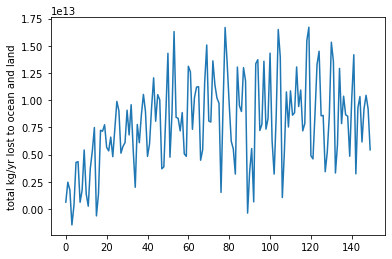

In [25]:
plt.plot(emis_sinks)
plt.ylabel('total kg/yr lost to ocean and land')

In [26]:
times = pd.date_range('2000', periods=len(co2_dif['time']), freq='MS')
weights = times.shift(1, 'MS') - times
weights = xr.DataArray(weights, [('time', co2_dif['time'].values)]).astype('float')

G_atm = (co2_dif * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


Text(0, 0.5, 'kg/yr in atmosphere')

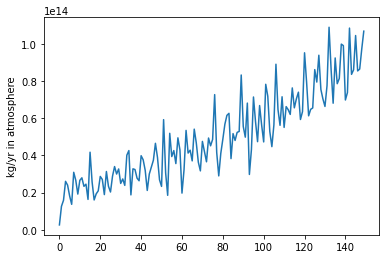

In [27]:
plt.plot(G_atm)
plt.ylabel('kg/yr in atmosphere')

In [28]:
emis_co2_ds = G_atm + emis_sinks

In [29]:
kg_CO2_to_GtC = 1/(1e12*3.67)

In [33]:
emis_co2_GtC_ds = emis_co2_ds*kg_CO2_to_GtC

emis_co2_ds =  ((np.array(G_atm_1pct_ds['co2_response'])/kg_to_Gt)[...,None,None] + 
        fg_co2_ds['fgco2'].isel(time = slice(0,len(G_atm_1pct_ds['co2_response']))) + 
        nbp_ds['nbp'].isel(time = slice(0,len(G_atm_1pct_ds['co2_response']))))

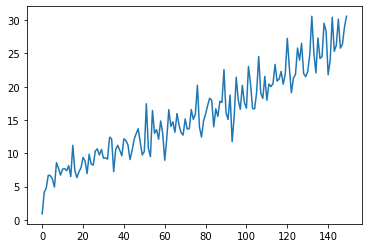

In [34]:
plt.plot(emis_co2_GtC_ds) #Gt/yr

# Save out CO2 emissions

In [35]:
#np.savetxt('1pct_emis_profile_derived.csv', np.array(list(E_base.values())), delimiter=',')
#np.savetxt('1pct_emis_profile_rcp85.csv', np.array(list(E_85.values())), delimiter=',')
np.savetxt('1pct_emis_profile_sinks.csv', np.array(emis_co2_GtC_ds))